<a href="https://colab.research.google.com/github/valeria-molino/MachineLearning-PredictiveModeling/blob/main/Predicting_Stress_Level.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [85]:
# 1 -- Libraries --
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from kagglehub import KaggleDatasetAdapter
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [54]:
# 2 -- Load the data --
file_path = "Impact_of_Remote_Work_on_Mental_Health.csv"
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "waqi786/remote-work-and-mental-health",
  file_path
)
print(df.head())
print('Dimensions: ', df.shape)

/tmp/ipython-input-2553257208.py:3: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


  Employee_ID  Age      Gender           Job_Role    Industry  \
0     EMP0001   32  Non-binary                 HR  Healthcare   
1     EMP0002   40      Female     Data Scientist          IT   
2     EMP0003   59  Non-binary  Software Engineer   Education   
3     EMP0004   27        Male  Software Engineer     Finance   
4     EMP0005   49        Male              Sales  Consulting   

   Years_of_Experience Work_Location  Hours_Worked_Per_Week  \
0                   13        Hybrid                     47   
1                    3        Remote                     52   
2                   22        Hybrid                     46   
3                   20        Onsite                     32   
4                   32        Onsite                     35   

   Number_of_Virtual_Meetings  Work_Life_Balance_Rating Stress_Level  \
0                           7                         2       Medium   
1                           4                         1       Medium   
2             

In [55]:
# 3 -- Data cleaning --
print(df.info())
#df = df.dropna()
#df = df.drop_duplicates()
#print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 20 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   Employee_ID                        5000 non-null   object
 1   Age                                5000 non-null   int64 
 2   Gender                             5000 non-null   object
 3   Job_Role                           5000 non-null   object
 4   Industry                           5000 non-null   object
 5   Years_of_Experience                5000 non-null   int64 
 6   Work_Location                      5000 non-null   object
 7   Hours_Worked_Per_Week              5000 non-null   int64 
 8   Number_of_Virtual_Meetings         5000 non-null   int64 
 9   Work_Life_Balance_Rating           5000 non-null   int64 
 10  Stress_Level                       5000 non-null   object
 11  Mental_Health_Condition            3804 non-null   object
 12  Access

In [56]:
print('Number of samples where both Mental_Health_Condition and Physical_Activity are missing: ', (df['Mental_Health_Condition'].isnull() & df['Physical_Activity'].isnull()).sum())

Number of samples where both Mental_Health_Condition and Physical_Activity are missing:  402


In [57]:
# We can drop samples where both Mental_Health_Condition and Physical_Activity are missing and fill the rest with the mode
df = df[~(df['Mental_Health_Condition'].isnull() & df['Physical_Activity'].isnull())]
df['Mental_Health_Condition'] = df['Mental_Health_Condition'].fillna(df['Mental_Health_Condition'].mode()[0])
df['Physical_Activity'] = df['Physical_Activity'].fillna(df['Physical_Activity'].mode()[0])
df.shape

(4598, 20)

In [58]:
# 4 -- Relation between Work_Location and Stress_Level
print(df['Work_Location'].unique())
print(df['Stress_Level'].unique())

['Hybrid' 'Remote' 'Onsite']
['Medium' 'High' 'Low']


In [59]:
stress_order = ['Medium', 'Low', 'High']
palette = sns.color_palette("RdYlBu_r", len(stress_order))
color_map = dict(zip(stress_order, palette))

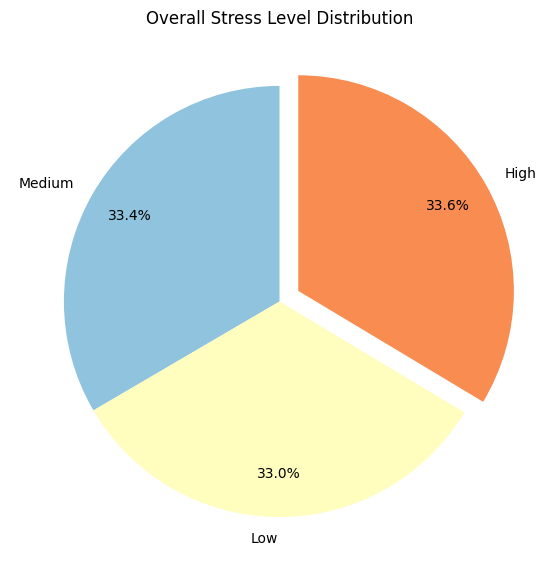

In [60]:
stress_counts = df['Stress_Level'].value_counts().reindex(stress_order)
colors = [color_map[level] for level in stress_counts.index]

plt.figure(figsize=(7,7))
plt.pie(stress_counts, labels=stress_counts.index, autopct="%1.1f%%", startangle=90,
        explode=[0.1 if i == 2 else 0 for i in range(len(stress_counts))],
        pctdistance=0.8, colors=colors)
plt.title('Overall Stress Level Distribution')
plt.show()

In [61]:
# Generate a cross tab (percetage of Stress_Level by Work_Location)
pd.crosstab(df['Work_Location'], df['Stress_Level'], normalize='index') * 100

Stress_Level,High,Low,Medium
Work_Location,,,
Hybrid,33.879423,33.224115,32.896461
Onsite,32.266667,33.866667,33.866667
Remote,34.605598,31.870229,33.524173


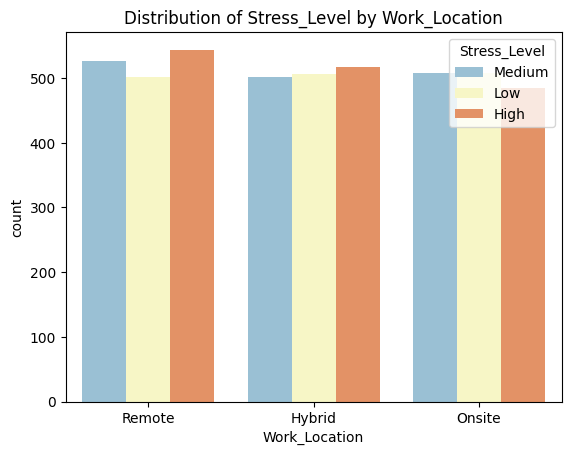

In [62]:
sns.countplot(data=df, x='Work_Location', hue='Stress_Level',
              order=df['Work_Location'].value_counts().index,
              hue_order=stress_order,
              palette=color_map)
plt.title('Distribution of Stress_Level by Work_Location')
plt.show()

In [63]:
# Test for statistic difference
cont_table = pd.crosstab(df['Work_Location'], df['Stress_Level'])
chi2, p, dof, expected = chi2_contingency(cont_table)
print(f"Chi2 = {chi2:.2f}, p-value = {p:.4f}")

Chi2 = 2.49, p-value = 0.6457


With a p-value of 0.65 (> 0.05), we fail to reject the null hypothesis. This suggests that the level of stress does not significantly differ across different work locations in this dataset.

In [64]:
# 4 -- Descriptive statistics by region --
print(df['Region'].unique())

['Europe' 'Asia' 'North America' 'Oceania' 'Africa' 'South America']


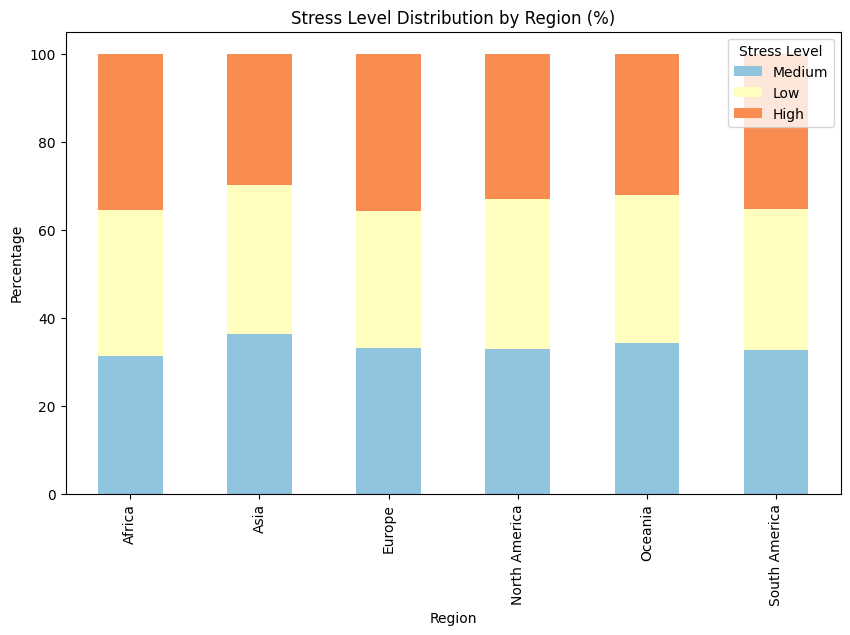

In [65]:
stat_by_class = (df.groupby('Region')['Stress_Level'].value_counts(normalize=True).unstack(fill_value=0).reindex(columns=stress_order) * 100 )
stat_by_class.plot(
    kind='bar', stacked=True, figsize=(10,6),
    color=[color_map[level] for level in stress_order]
)

plt.title('Stress Level Distribution by Region (%)')
plt.xlabel('Region')
plt.ylabel('Percentage')
plt.legend(title='Stress Level', loc='upper right')
plt.show()

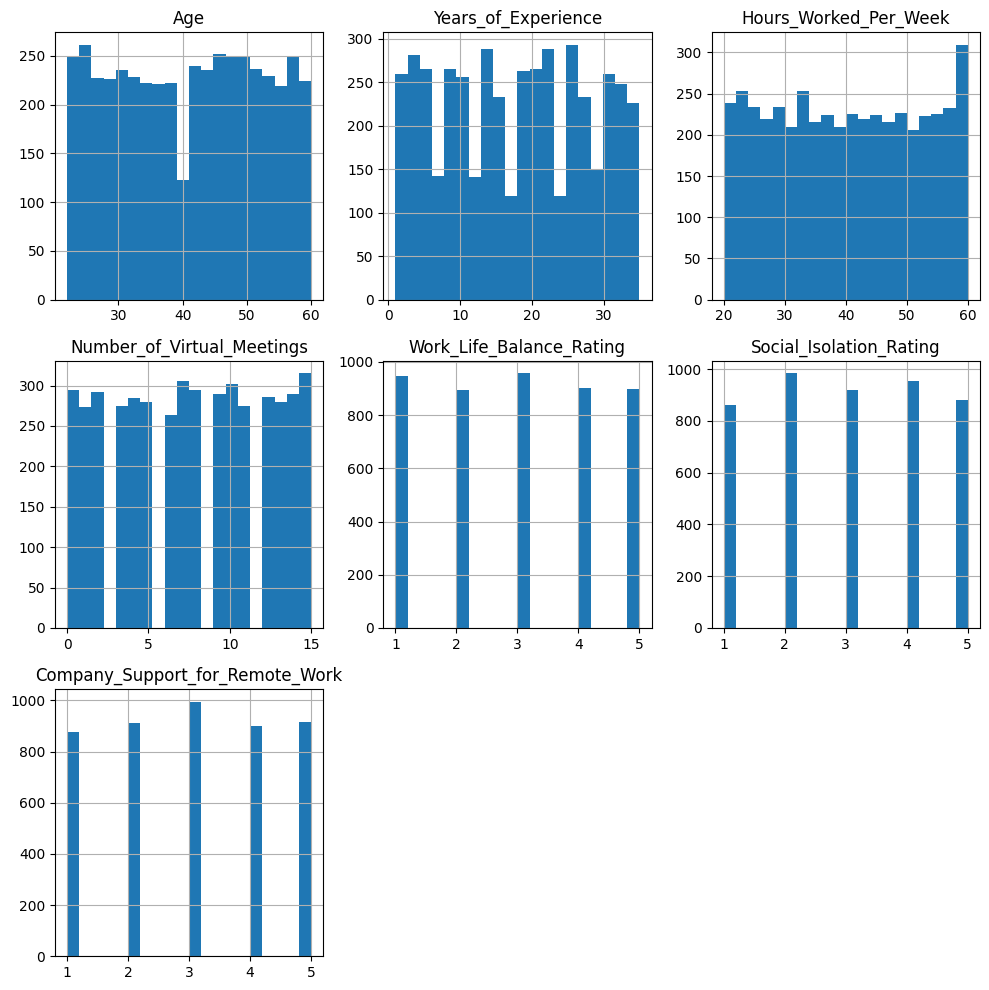

In [66]:
df.select_dtypes(include=[np.number]).hist(bins=20, figsize=(10,10))
plt.tight_layout()
plt.show()

In [70]:
# 5 -- Data preparation --
# Convert categorical variables into numeric
df = df.drop(['Employee_ID'], axis=1)
cat_columns = df.select_dtypes(['object']).columns
# Convert
encoder = LabelEncoder()
for col in cat_columns:
    df[col] = encoder.fit_transform(df[col])
df.head()

,Age,Gender,Job_Role,Industry,Years_of_Experience,Work_Location,Hours_Worked_Per_Week,Number_of_Virtual_Meetings,Work_Life_Balance_Rating,Stress_Level,Mental_Health_Condition,Access_to_Mental_Health_Resources,Productivity_Change,Social_Isolation_Rating,Satisfaction_with_Remote_Work,Company_Support_for_Remote_Work,Physical_Activity,Sleep_Quality,Region
0,32,2,2,3,13,0,47,7,2,2,2,0,0,1,2,1,1,1,2
1,40,0,0,4,3,2,52,4,1,2,0,0,1,3,1,2,1,1,1
2,59,2,6,1,22,0,46,11,5,2,0,0,2,4,2,5,1,2,3
3,27,1,6,2,20,1,32,8,4,0,2,1,1,3,2,3,1,2,2
4,49,1,5,0,32,1,35,12,2,0,1,1,0,3,2,3,1,0,3


In [71]:
# Select features X and target y
X = df.drop(['Stress_Level'], axis=1)
y = df['Stress_Level']

In [72]:
# Splitting into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [77]:
# Model training
model = RandomForestClassifier()
params= {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 5, 10],
    'max_features': [0.3, 0.5, 0.7]
}
grid = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [10, 15, 20],
                         'max_features': [0.3, 0.5, 0.7],
                         'min_samples_leaf': [2, 5, 10],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=1)

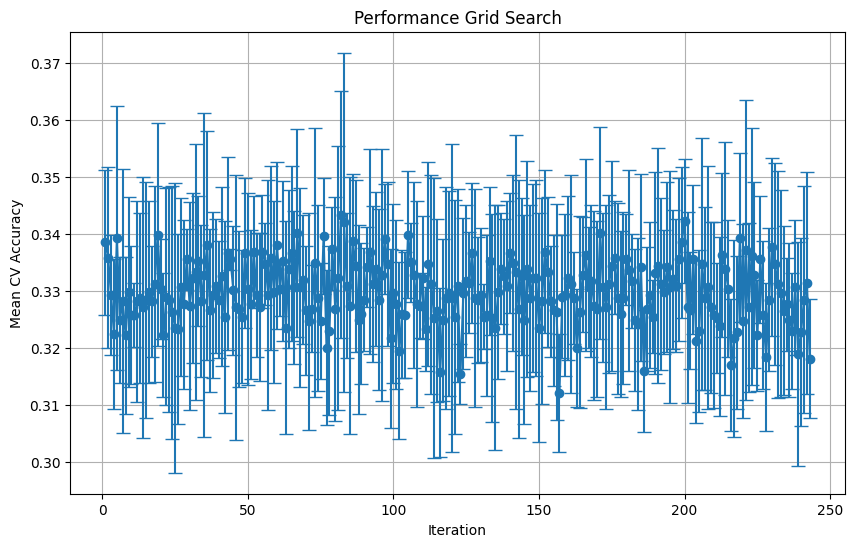

In [78]:
grid_search = pd.DataFrame(grid.cv_results_)
mean_scores_grid_search = grid_search['mean_test_score']
std_scores_grid_search = grid_search['std_test_score']

plt.figure(figsize=(10,6))
plt.errorbar(range(1, len(mean_scores_grid_search)+1), mean_scores_grid_search, yerr=std_scores_grid_search, fmt='o-', capsize=5)
plt.xlabel('Iteration')
plt.ylabel('Mean CV Accuracy')
plt.title('Performance Grid Search')
plt.grid(True)
plt.show()

In [84]:
print("Best parameters:", grid.best_params_)
print("Best cross-val accuracy:", grid.best_score_)

Best parameters: {'max_depth': 15, 'max_features': 0.3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Best cross-val accuracy: 0.34338065661047024


The accuracy score is too small

/tmp/ipython-input-3599162310.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mi_series.values, y=mi_series.index, palette="viridis")


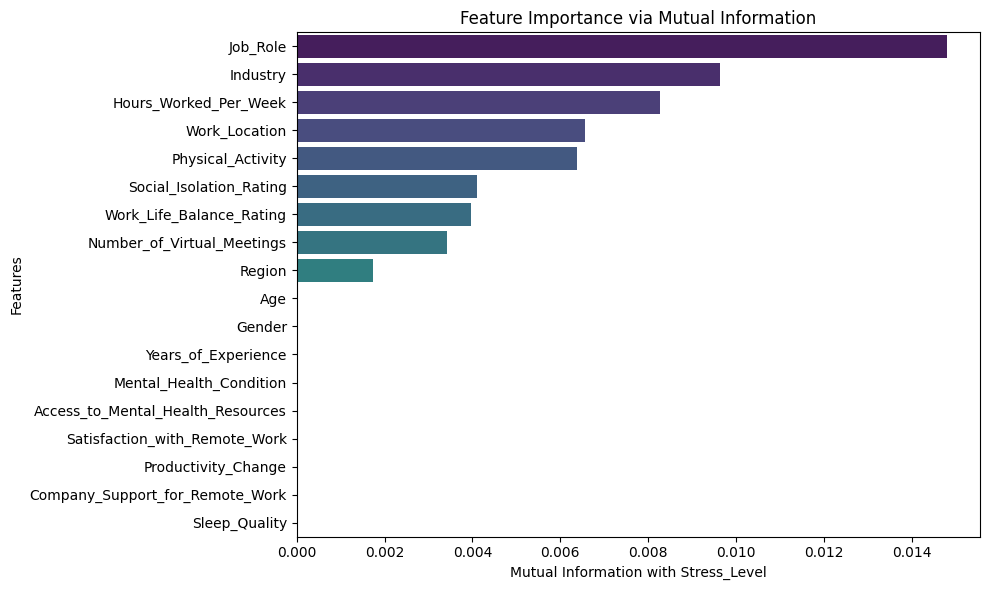

In [87]:
# Mutual Information
mi = mutual_info_classif(X, y)
mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=mi_series.values, y=mi_series.index, palette="viridis")
plt.xlabel("Mutual Information with Stress_Level")
plt.ylabel("Features")
plt.title("Feature Importance via Mutual Information")
plt.tight_layout()
plt.show()

The mutual information analysis shows that Hours_Worked_Per_Week,
Company_Support_for_Remote_Work, and Industry provide the most information
about stress levels, though the values are overall low. This suggests that stress
is influenced by complex interactions between features rather than any single variable.
Features with zero MI may still be useful in combination with others or through non-linear models.
Next steps include model-based feature importance,
and regularization to focus on the most informative predictors.

In [92]:
# Model training
X = df.drop(['Stress_Level', 'Age', 'Gender', 'Years_of_Experience',
             'Mental_Health_Condition', 'Access_to_Mental_Health_Resources',
             'Satisfaction_with_Remote_Work', 'Productivity_Change',
             'Company_Support_for_Remote_Work', 'Sleep_Quality'], axis=1)
y = df['Stress_Level']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
grid = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [10, 15, 20],
                         'max_features': [0.3, 0.5, 0.7],
                         'min_samples_leaf': [2, 5, 10],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=1)

In [94]:
print("Best parameters:", grid.best_params_)
print("Best cross-val accuracy:", grid.best_score_)
best_model = grid.best_estimator_

Best parameters: {'max_depth': 15, 'max_features': 0.7, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 50}
Best cross-val accuracy: 0.3458370304643596


In [95]:
# Model Evaluation
y_predict = best_model.predict(X_test)
accuracy_score = accuracy_score(y_test, y_predict)
print("Best cross-val accuracy:", accuracy_score)

Best cross-val accuracy: 0.32717391304347826


In [98]:
cm = confusion_matrix(y_test, y_predict)
print(cm)

[[109  85  95]
 [ 93  96 148]
 [117  81  96]]


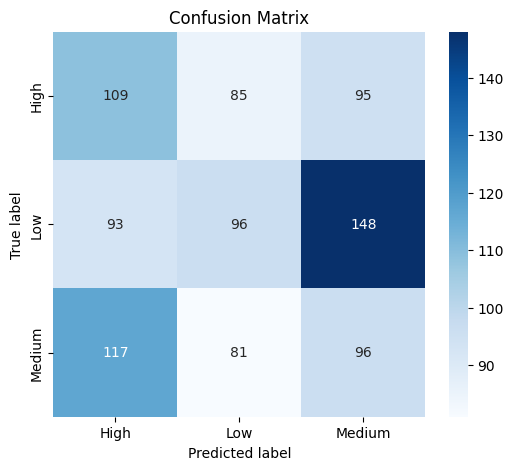

              precision    recall  f1-score   support

           0       0.34      0.38      0.36       289
           1       0.37      0.28      0.32       337
           2       0.28      0.33      0.30       294

    accuracy                           0.33       920
   macro avg       0.33      0.33      0.33       920
weighted avg       0.33      0.33      0.33       920



In [102]:
cm = confusion_matrix(y_test, y_predict)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['High','Low', 'Medium'], yticklabels=['High','Low', 'Medium'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, y_predict))

The classification results indicate that the features provided in the dataset are not effective predictors of stress levels. Even the more informative features, such as Hours_Worked_Per_Week and Company_Support_for_Remote_Work, contribute very little to distinguishing between classes. This observation is consistent with previous analyses: neither region nor work modality showed statistically significant differences in stress levels. Overall, this suggests that stress is likely influenced by factors not captured in this dataset, and additional or more detailed data would be needed to build a predictive model.